In [1]:
import sys
sys.path.insert(0, '/home/dom/AIR/air25')

import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from src.a1.pipeline import run_pipeline
from src.a1.eval import evaluate_voting_results
from src.config import CLAIMS_PATH, EVIDENCE_PATH, MAPPINGS_PATH
import joblib

/home/tristan/PycharmProjects/air25/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config

RANDOM_STATE = 21
TEST_SIZE = 0.2

In [3]:
# create validation batch

all_claims = pd.read_csv(CLAIMS_PATH)

train_set, val_set = train_test_split(
    all_claims,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=all_claims['claim_label']
)

print(f"Validation batch size: {len(val_set)}")

Validation batch size: 276


In [4]:
# run

#results = run_pipeline(claims_df=val_set, k_retrieve=20)
#joblib.dump(results, 'pipeline_results_1_ret.joblib')

results = joblib.load('pipeline_results_1_ret.joblib')

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# Eval

acc, f1_macro, f1_weighted, report, y_pred, y_true = evaluate_voting_results(results, CLAIMS_PATH)

print(f"Accuracy: {acc:.4f}")
print(f"F1_Macro: {f1_macro:.4f}")
print(f"F1_Weighted: {f1_weighted:.4f}")
print(f"Classification report: {report}")

Accuracy: 0.2971
F1_Macro: 0.2906
F1_Weighted: 0.2768
Classification report:                  precision    recall  f1-score   support

NOT_ENOUGH_INFO       0.33      0.26      0.29        94
        REFUTES       0.22      0.76      0.34        51
       SUPPORTS       0.76      0.15      0.24       131

       accuracy                           0.30       276
      macro avg       0.44      0.39      0.29       276
   weighted avg       0.51      0.30      0.28       276



In [6]:
# CM

VALID_LABELS = ['SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO']
cm = confusion_matrix(y_true, y_pred, labels=VALID_LABELS)
print("Confusion Matrix:")
print(f"Labels: {VALID_LABELS}")
print(cm)

Confusion Matrix:
Labels: ['SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO']
[[19 74 38]
 [ 2 39 10]
 [ 4 66 24]]


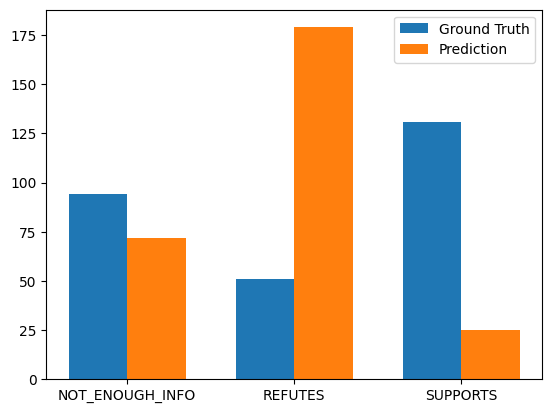

In [7]:
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np

gt_counts = Counter(y_true)
pred_counts = Counter(y_pred)
labels = ['NOT_ENOUGH_INFO', 'REFUTES', 'SUPPORTS']
gt_vals = [gt_counts.get(k, 0) for k in labels]
pred_vals = [pred_counts.get(k, 0) for k in labels]

x = np.arange(len(labels))
w = 0.35

plt.bar(x - w/2, gt_vals, w, label='Ground Truth')
plt.bar(x + w/2, pred_vals, w, label='Prediction')

plt.xticks(x, labels)
plt.legend()
plt.show()

In [20]:
# Class Pred

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=VALID_LABELS, zero_division=0)

per_class_df = pd.DataFrame({
    'Class': VALID_LABELS,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(per_class_df.to_string(index=False))

          Class  Precision   Recall  F1-Score  Support
       SUPPORTS   0.888889 0.122137  0.214765      131
        REFUTES   0.221053 0.823529  0.348548       51
NOT_ENOUGH_INFO   0.397059 0.287234  0.333333       94


In [21]:
import numpy as np

# Save for comparison notebook
results_dict = {
    'results': results,
    'y_true': y_true,
    'y_pred': y_pred,
    'accuracy': acc,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'confusion_matrix': cm,
    'per_class': per_class_df.to_dict(),
}

np.save('eval_results_a1.npy', results_dict, allow_pickle=True)